# CNN implementation for Hurricane damage classification

In [30]:
# Import libraries
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
from glob import glob
import random
import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from tensorflow.keras import layers
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns
import warnings
from tensorflow.keras.applications.vgg16 import VGG16

pd.set_option('display.max_colwidth', None)

In [5]:
# Collect all images
img_paths=[]
img_labels=[]
for i in glob('Archive\\**',recursive=True):
    if i.endswith('.jpeg'):
        a=i.split('\\')
        img_paths.append(i)
        img_labels.append(a[-2])

In [9]:
# Check the number of the images
len(img_paths),len(img_labels)

(23000, 23000)

In [14]:
# Combine the location of the image with the label
img_path = pd.Series(img_paths).astype(str)
labels=pd.Series(img_labels)
data = pd.concat([img_path,labels],axis=1)
data.sample(5)

,0,1
8228,Archive\test_another\damage\-95.63911_29.840604.jpeg,damage
22602,Archive\validation_another\no_damage\-95.63499300000001_29.839260999999997.jpeg,no_damage
5321,Archive\test_another\damage\-95.555356_29.765248.jpeg,damage
1988,Archive\test\no_damage\-96.996227_28.525205.jpeg,no_damage
1905,Archive\test\no_damage\-96.93650699999999_28.728113.jpeg,no_damage


#### The distribution of classes

From the bar chart it is apparent that the data set is moderately imbalanced.

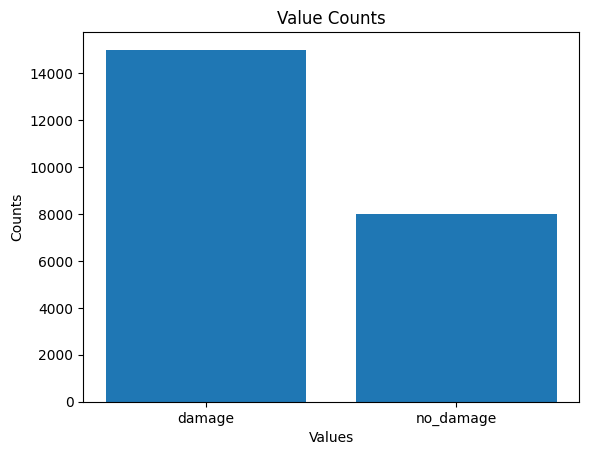

In [18]:
# Count values of both classes
value_counts = data[1].value_counts()

# Create a bar chart
plt.bar(value_counts.index, value_counts.values)

# Set the plot title and axis labels
plt.title('Value Counts')
plt.xlabel('Values')
plt.ylabel('Counts')

# Display the plot
plt.show()


In [23]:
# Divide data into train and test datasets
train_set , test_set = train_test_split(data,test_size=0.25,random_state=0)
train_set.shape,test_set.shape

((17250, 2), (5750, 2))

In [24]:
# Set parameters to generate batches of image data
train_gen = ImageDataGenerator(
        # Set a fraction of images reserved for validation
        validation_split=0.1,
        # Set a rescaling factor to rescale images
        rescale=1/255,
        ) 

test_gen = ImageDataGenerator(
    # Set a rescaling factor to rescale images
    rescale=1/255
)

# Generate batches of training data
data_train = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training',
    batch_size=32,
    seed=2020
)

# Generate batches of validation data
data_val = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    subset = 'validation',
    batch_size=32,
    seed=2020
)

# Generate batches of testing data
data_test = test_gen.flow_from_dataframe(
    dataframe = test_set,
    x_col = 0,
    y_col = 1,
    target_size = (128,128),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size=32,
    seed=2020
)

Found 15525 validated image filenames belonging to 2 classes.
Found 1725 validated image filenames belonging to 2 classes.
Found 5750 validated image filenames belonging to 2 classes.


### Importing images

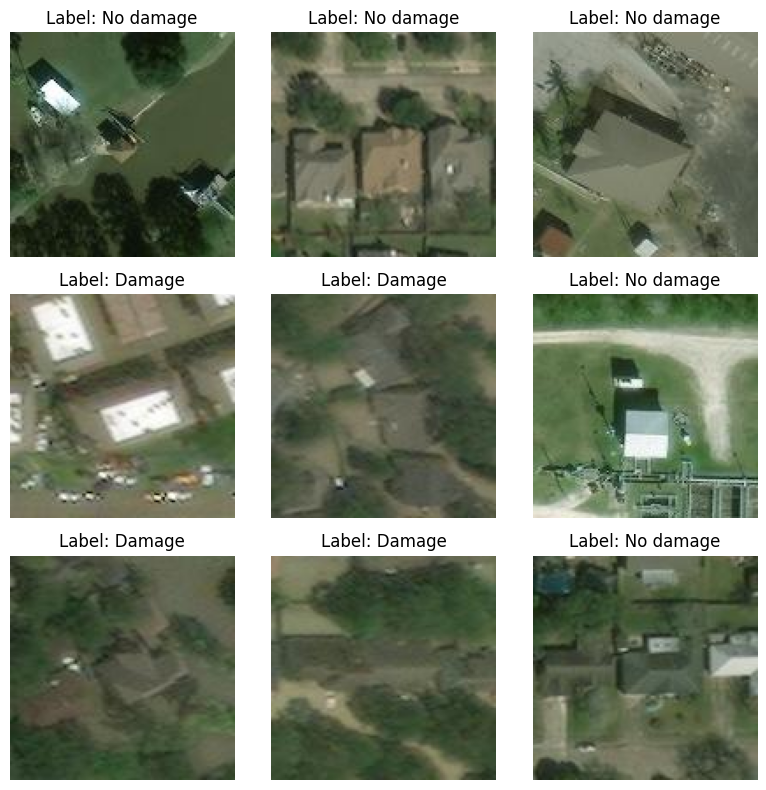

In [25]:
# Retrieve the first batch from data generator
batch_images, batch_labels = next(data_train)

label_dict = {
    0: "Damage", 
    1: "No damage"
}

# Plot 9 images from the batch
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8,8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(batch_images[i])
    ax.axis('off')
    ax.set_title(f'Label: {label_dict[batch_labels[i].argmax()]}')
plt.tight_layout()

plt.savefig('plot.png')

plt.show()

## AlexNet

### AlexNet explanation

### AlexNet

**AlexNet modified architecture:**

$$
(C N N \rightarrow R N \rightarrow M P)^2 \rightarrow\left(C N N^3 \rightarrow M P\right) \rightarrow(F C \rightarrow D O)^2 \rightarrow \text { Linear } \rightarrow \text { sigmoid }
$$

Where

- $CNN$ = convolutional layer (with ReLU activation)
- $RN$ = local response normalization
- $MP$ = maxpooling
- $FC$ = fully connected layer (with ReLU activation)
- $Linear$ = fully connected layer (without activation)
- $DO$ = dropout

**********************Key points:**********************

1. The ReLU activation function is used instead of Tanh to introduce non-linearity, resulting in a six-fold increase in speed while maintaining the same accuracy.
2. To address overfitting, dropout is used instead of regularization. However, it should be noted that using a dropout rate of 0.5 doubles the training time.
3. Max pooling is used to reduce the size of the network. 

**Reduction of overfitting:**

1. Dropout with a rate of 50% is applied to two fully connected layers at the end.
2. Testing 40 different combinations of optimization methods (Adam, RMSprop, SGD) and learning rates.
3. EarlyStopping with a patience of 1 epoch and min $\Delta = 0.01$ in validation accuracy metric.

Data augmentation is a common technique to reduce overfitting, however it is not used due to computational limitations. The model does not overfit when comparing accuracy results on the validation and test datasets.

Krizhevsky, A., Sutskever, I. and Hinton, G.E. (2017) “ImageNet classification with deep convolutional Neural Networks,” Communications of the ACM, 60(6), pp. 84–90. Available at: https://doi.org/10.1145/3065386. 

### AlexNet application

In [38]:
# Set learning rates for a random search
learning_rates = list(np.logspace(-7, -4, 20))
print(learning_rates)

[1e-07, 1.438449888287663e-07, 2.06913808111479e-07, 2.976351441631319e-07, 4.281332398719396e-07, 6.158482110660267e-07, 8.858667904100833e-07, 1.2742749857031322e-06, 1.8329807108324375e-06, 2.6366508987303555e-06, 3.7926901907322535e-06, 5.455594781168514e-06, 7.847599703514607e-06, 1.1288378916846883e-05, 1.623776739188721e-05, 2.3357214690901213e-05, 3.359818286283781e-05, 4.8329302385717524e-05, 6.951927961775606e-05, 0.0001]


In [41]:
# Define a neural network
def create_model_alexnet(hp):
    model = keras.Sequential()
    model.add(layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(128,128,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(3,3), strides=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='sigmoid'))
    
    # Set possible optimizers
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop']), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    # Set possible learning rates
    model.optimizer.learning_rate = hp.Choice('learning_rate', values=[1e-07, 1.438449888287663e-07, 2.06913808111479e-07, 2.976351441631319e-07, 4.281332398719396e-07, 6.158482110660267e-07, 8.858667904100833e-07, 1.2742749857031322e-06, 1.8329807108324375e-06, 2.6366508987303555e-06, 3.7926901907322535e-06, 5.455594781168514e-06, 7.847599703514607e-06, 1.1288378916846883e-05, 1.623776739188721e-05, 2.3357214690901213e-05, 3.359818286283781e-05, 4.8329302385717524e-05, 6.951927961775606e-05, 0.0001]
)
    return model

# Define the search space of hyperparameters
tuner_hp = HyperParameters()
tuner_hp.Choice('optimizer', values=['adam', 'sgd', "rmsprop"])
tuner_hp.Choice('learning_rate', values=[1e-07, 1.438449888287663e-07, 2.06913808111479e-07, 2.976351441631319e-07, 4.281332398719396e-07, 6.158482110660267e-07, 8.858667904100833e-07, 1.2742749857031322e-06, 1.8329807108324375e-06, 2.6366508987303555e-06, 3.7926901907322535e-06, 5.455594781168514e-06, 7.847599703514607e-06, 1.1288378916846883e-05, 1.623776739188721e-05, 2.3357214690901213e-05, 3.359818286283781e-05, 4.8329302385717524e-05, 6.951927961775606e-05, 0.0001]
)

# Create the tuner object
tuner = RandomSearch(
    create_model_alexnet,
    hyperparameters=tuner_hp,
    objective='val_accuracy',
    max_trials=40,
    overwrite = True,
    project_name='my_project')

now = datetime.datetime.now()
log_dir = f"./logs_alexnet_{now.strftime('%Y.%m.%d_%H.%M')}"

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0,
                          write_graph=True, write_images=False)

# Add a ModelCheckpoint callback to save the best model during training
checkpoint_filepath = f"model_checkpoints/best_model_{now.strftime('%Y.%m.%d_%H.%M')}.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss')


early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=2, 
    mode = "max", 
    # start_from_epoch=2,
    min_delta=0.01
    )

# Run the search
tuner.search(data_train, 
             epochs=20, 
             validation_data = data_val, 
             callbacks=[tensorboard, early_stopping, checkpoint_callback]
             )

Trial 37 Complete [00h 06m 01s]
val_accuracy: 0.8689855337142944

Best val_accuracy So Far: 0.9518840909004211
Total elapsed time: 03h 11m 33s
INFO:tensorflow:Oracle triggered exit


In [42]:
# Extract the best model
model_alex_best=tuner.get_best_models()[0]

In [43]:
# Extract the parameters of the best model
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
learning_rate = best_hyperparameters.get('learning_rate')
optimizer = best_hyperparameters.get('optimizer')
print(f"Best learning rate: {learning_rate}")
print(f"Best optimizer: {optimizer}")

Best learning rate: 3.7926901907322535e-06
Best optimizer: rmsprop


In [251]:
# Evaluate the accuracy of the best model on the test data
model_alex_best.evaluate(data_test, verbose=2)

2023-03-19 22:27:32.288608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


180/180 - 9s - loss: 0.1674 - accuracy: 0.9410 - 9s/epoch - 52ms/step


[0.16735555231571198, 0.9410435557365417]

In [108]:
# Calculate metrics
y_pred_alex = model_alex_best.predict(data_test)
y_proba_alex = np.max(y_pred_alex, axis = 1)
y_prob_1_alex = y_pred_alex[:, 1]
y_pred_bin_alex = np.argmax(y_pred_alex,axis=1)
print(classification_report(data_test.labels,y_pred_bin_alex))

2023-03-18 18:07:55.146780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 4s 19ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      3694
           1       0.94      0.90      0.92      2056

    accuracy                           0.94      5750
   macro avg       0.94      0.93      0.94      5750
weighted avg       0.94      0.94      0.94      5750



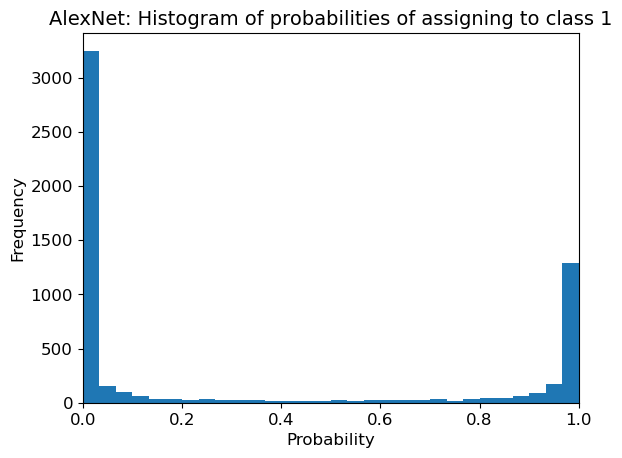

In [116]:
# Plot a histogram of probabilities
plt.hist(y_prob_1_alex, bins=30)
# Set the x limits
plt.xlim(0, 1) 
plt.title("AlexNet: Histogram of probabilities of assigning to class 1", fontsize=14) 
plt.xlabel("Probability", fontsize=12)
plt.ylabel("Frequency", fontsize=12)  
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.show()

In [123]:
# Calculate a confusion matrix
classes=['Damage','No Damage']
con_mat_df_alex = pd.DataFrame(confusion_matrix(data_test.labels,y_pred_bin_alex),
                     index = classes, 
                     columns = classes)


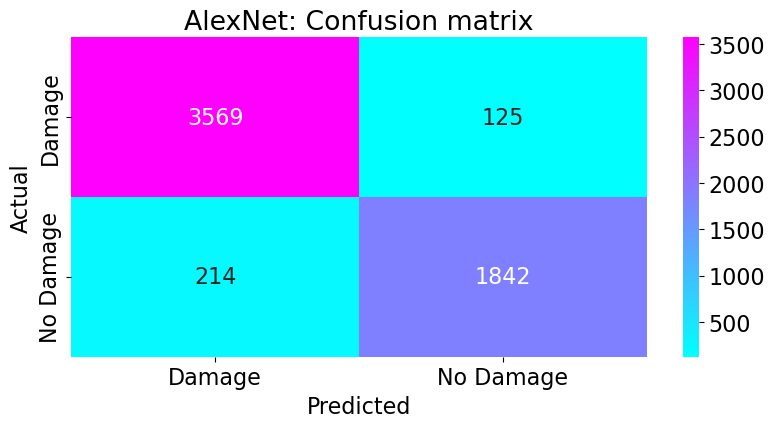

In [125]:
# Plot a confusion matrix
figure = plt.figure(figsize=(8, 4))
sns.heatmap(con_mat_df_alex, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("AlexNet: Confusion matrix") 
plt.show()

In [61]:
#### Evaluation functions for binary classification problems

warnings.simplefilter(action='ignore', category=FutureWarning)

# Calculate the FPR and TPR for all thresholds of the classification

# Create a function to report metrics
def confusion_metrics(conf_matrix):
# Save the confusion matrix and slice it into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)
    
    # Calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    # Calculate misclassification rate
    conf_misclassification = 1- conf_accuracy
    # Calculate sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate specificity
    conf_specificity = (TN / float(TN + FP))
    
    # Calculate precision
    conf_precision = (TP / float(TP + FP))
    # Calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,2)}') 
    print(f'Mis-Classification: {round(conf_misclassification,2)}') 
    print(f'Sensitivity: {round(conf_sensitivity,2)}') 
    print(f'Specificity: {round(conf_specificity,2)}') 
    print(f'Precision: {round(conf_precision,2)}')
    print(f'f_1 Score: {round(conf_f1,2)}')



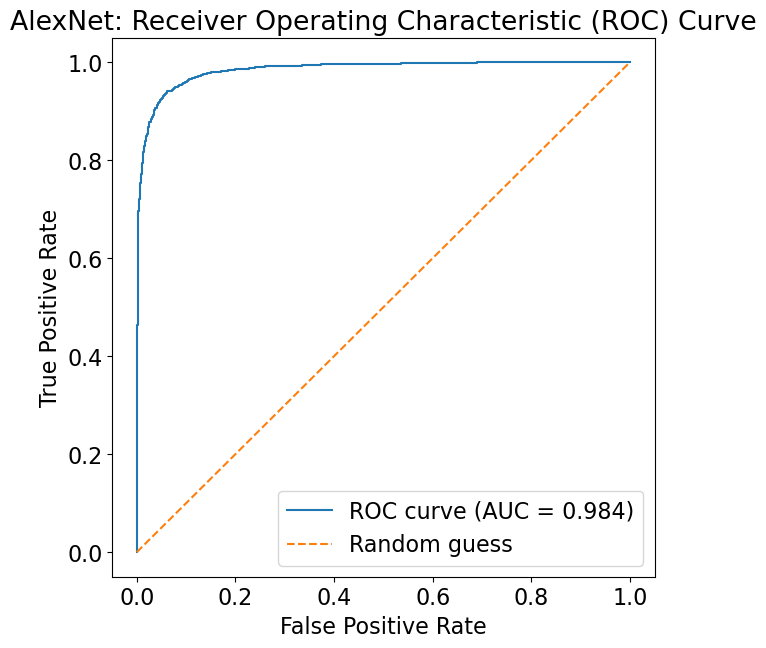

In [121]:
# Calculate the FPR and TPR
fpr_alex, tpr_alex, thresholds_alex = roc_curve(data_test.labels, y_prob_1_alex)
auc_score_alex = roc_auc_score(data_test.labels, y_prob_1_alex)
plt.figure(figsize=(7, 7))
# Plot the ROC curve
plt.plot(fpr_alex, tpr_alex, label=f'ROC curve (AUC = {auc_score_alex:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AlexNet: Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [68]:
# Calculate metrics
con_mat_df_alex.to_numpy()
confusion_metrics(con_mat_df_alex.to_numpy())

True Positives: 1842
True Negatives: 3569
False Positives: 125
False Negatives: 214
--------------------------------------------------
Accuracy: 0.94
Mis-Classification: 0.06
Sensitivity: 0.9
Specificity: 0.97
Precision: 0.94
f_1 Score: 0.92


### Confusion matrix metrics
Here are the explanations of each metric and how they are calculated:

Accuracy: Accuracy measures the overall correctness of the model predictions. It is calculated as the ratio of correctly classified instances to the total number of instances in the dataset.
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives, and FN is the number of false negatives.

Misclassification rate: Misclassification rate is the complement of accuracy and measures the overall incorrectness of the model predictions. It is calculated as the ratio of incorrectly classified instances to the total number of instances in the dataset.
$$\text{Misclassification rate} = 1 - Accuracy$$

Sensitivity: Sensitivity (also known as recall or true positive rate) measures the proportion of actual positive instances that are correctly identified by the model. It is calculated as the ratio of true positives to the sum of true positives and false negatives.
$$Sensitivity = \frac{TP}{TP + FN}$$

Specificity: Specificity measures the proportion of actual negative instances that are correctly identified by the model. It is calculated as the ratio of true negatives to the sum of true negatives and false positives.
$$Specificity = \frac{TN}{TN + FP}$$

Precision: Precision measures the proportion of positive predictions that are actually true positive instances. It is calculated as the ratio of true positives to the sum of true positives and false positives.
$$Precision = \frac{TP}{TP + FP}$$

F1 Score: F1 score is the harmonic mean of precision and sensitivity. It provides a balance between precision and sensitivity and is a popular metric for imbalanced datasets where one class is much more frequent than the other.
$$F1 Score = 2 * \frac{Precision * Sensitivity}{Precision + Sensitivity}$$

Overall, these metrics are important for evaluating the performance of a classification model and understanding its strengths and weaknesses. High accuracy, sensitivity, specificity, and precision are desirable, while low mis-classification and a high F1 score indicate a well-performing model.

The model performs at a satisfactory level in each metric. Since specificity is higher than sensitivity, it indicates that the model has better performance in classifying instances where there is no damage compared to instances with damage. However, since we are more concerned about accurately classifying damaged objects, we should tune AlexNet to improve its sensitivity metric (classifying true positives) for better performance in this aspect.





## VGG 16

In [70]:
# Set the dimensions
IMG_SHAPE = (128, 128, 3)

# Create the base model from the pre-trained VGG16 model 
pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                     include_top=False,
                                                     weights='imagenet')

# Freeze the convolutional base
pretrained_model.trainable = False

In [71]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [187]:
# Possible learning rates for a random search
list(np.logspace(-6, -3,  20))

[1e-06, 1.438449888287663e-06, 2.06913808111479e-06, 2.976351441631319e-06, 4.281332398719396e-06, 6.158482110660267e-06, 8.858667904100832e-06, 1.274274985703132e-05, 1.8329807108324375e-05, 2.6366508987303556e-05, 3.792690190732254e-05, 5.4555947811685143e-05, 7.847599703514606e-05, 0.00011288378916846884, 0.0001623776739188721, 0.00023357214690901214, 0.0003359818286283781, 0.0004832930238571752, 0.0006951927961775605, 0.001]


In [ ]:
# Define a neural network
def create_model_vgg16(hp):
    model = Sequential()
    model.add(VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    model.optimizer.learning_rate = hp.Choice('learning_rate', values= [1e-06, 1.438449888287663e-06, 2.06913808111479e-06, 2.976351441631319e-06, 4.281332398719396e-06, 6.158482110660267e-06, 8.858667904100832e-06, 1.274274985703132e-05, 1.8329807108324375e-05, 2.6366508987303556e-05, 3.792690190732254e-05, 5.4555947811685143e-05, 7.847599703514606e-05, 0.00011288378916846884, 0.0001623776739188721, 0.00023357214690901214, 0.0003359818286283781, 0.0004832930238571752, 0.0006951927961775605, 0.001]
                                              )

    return model

# Define the search space of hyperparameters
tuner_hp = HyperParameters()
tuner_hp.Choice('optimizer', values=['adam', 'rmsprop'])
tuner_hp.Choice('learning_rate', values= [1e-06, 1.438449888287663e-06, 2.06913808111479e-06, 2.976351441631319e-06, 4.281332398719396e-06, 6.158482110660267e-06, 8.858667904100832e-06, 1.274274985703132e-05, 1.8329807108324375e-05, 2.6366508987303556e-05, 3.792690190732254e-05, 5.4555947811685143e-05, 7.847599703514606e-05, 0.00011288378916846884, 0.0001623776739188721, 0.00023357214690901214, 0.0003359818286283781, 0.0004832930238571752, 0.0006951927961775605, 0.001])
# Create the tuner object
tuner = RandomSearch(
    create_model_vgg16,
    hyperparameters=tuner_hp,
    objective='val_accuracy',
    max_trials=40,
    overwrite = True,
    project_name='my_project')

now = datetime.datetime.now()
log_dir = f"./logs_vgg16_{now.strftime('%Y.%m.%d_%H.%M')}"

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0,
                          write_graph=True, write_images=False)

# Add a ModelCheckpoint callback to save the best model during training
checkpoint_filepath = f"model_checkpoints/best_model_vgg_{now.strftime('%Y.%m.%d_%H.%M')}.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss')

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=2, 
    mode = "max", 
    min_delta=0.0005
    )

# Run the search
tuner.search(data_train, 
             epochs=15, 
             validation_data = data_val, 
             callbacks=[tensorboard, early_stopping, checkpoint_callback]
             )

The parameter tuning procedure was stopped after 8 trials due to high computational costs. After running 8 randomly chosen combinations, the model with the highest accuracy was the one with:
- Adam optimizer
- learning rate: 0.0000029764 

Below there is an optimization with only this model.

In [244]:
# Define a neural network
def create_model_vgg16(hp):
    model = Sequential()
    model.add(VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='sigmoid'))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam']),
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    model.optimizer.learning_rate = hp.Choice('learning_rate', values=[0.0000029764]
                                              )

    return model

# Define the search space of hyperparameters
tuner_hp = HyperParameters()
tuner_hp.Choice('optimizer', values=['adam'])
tuner_hp.Choice('learning_rate', values=[0.0000029764])

# Create the tuner object
tuner = RandomSearch(
    create_model_vgg16,
    hyperparameters=tuner_hp,
    objective='val_accuracy',
    max_trials=16,
    overwrite = True,
    project_name='my_project')

now = datetime.datetime.now()
log_dir = f"./logs_vgg16_{now.strftime('%Y.%m.%d_%H.%M')}"

tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=0,
                          write_graph=True, write_images=False)

# Add a ModelCheckpoint callback to save the best model during training
checkpoint_filepath = f"model_checkpoints/best_model_vgg_{now.strftime('%Y.%m.%d_%H.%M')}.h5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss')

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=2, 
    mode = "max", 
    min_delta=0.0005
    )

# Run the search
tuner.search(data_train, 
             epochs=15, 
             validation_data = data_val, 
             callbacks=[tensorboard, early_stopping, checkpoint_callback]
             )

Trial 1 Complete [00h 40m 29s]
val_accuracy: 0.9802899360656738

Best val_accuracy So Far: 0.9802899360656738
Total elapsed time: 00h 40m 29s
INFO:tensorflow:Oracle triggered exit


In [245]:
# Extract the best model
model_vgg_best=tuner.get_best_models()[0]
model_vgg_best.evaluate(data_test, verbose=2)

2023-03-19 18:46:42.534125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


180/180 - 37s - loss: 0.0501 - accuracy: 0.9810 - 37s/epoch - 204ms/step


[0.05006135627627373, 0.9810435175895691]

In [246]:
# Calculate metrics
y_pred_vgg = model_vgg_best.predict(data_test)
y_proba_vgg = np.max(y_pred_vgg, axis = 1)
y_prob_1_vgg = y_pred_vgg[:, 1]
y_pred_bin_vgg = np.argmax(y_pred_vgg,axis=1)
print(classification_report(data_test.labels,y_pred_bin_vgg))

2023-03-19 18:53:45.463850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


180/180 [==============================] - 27s 147ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3694
           1       0.98      0.97      0.97      2056

    accuracy                           0.98      5750
   macro avg       0.98      0.98      0.98      5750
weighted avg       0.98      0.98      0.98      5750



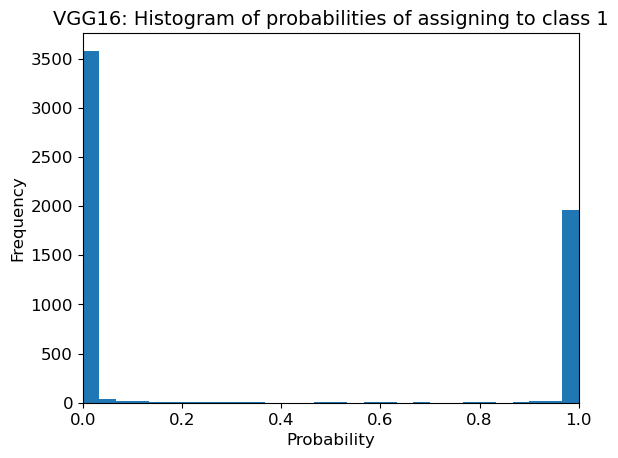

In [117]:
# Plot a histogram of probabilities
plt.hist(y_prob_1_vgg, bins=30)
#  Set the x limits
plt.xlim(0, 1) 
plt.title("VGG16: Histogram of probabilities of assigning to class 1", fontsize=14) 
plt.xlabel("Probability", fontsize=12) 
plt.ylabel("Frequency", fontsize=12) 
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.show()

In [247]:
# Calculate a confusion matrix
classes=['Damage','No Damage']
con_mat_df_vgg = pd.DataFrame(confusion_matrix(data_test.labels,y_pred_bin_vgg),
                     index = classes, 
                     columns = classes)


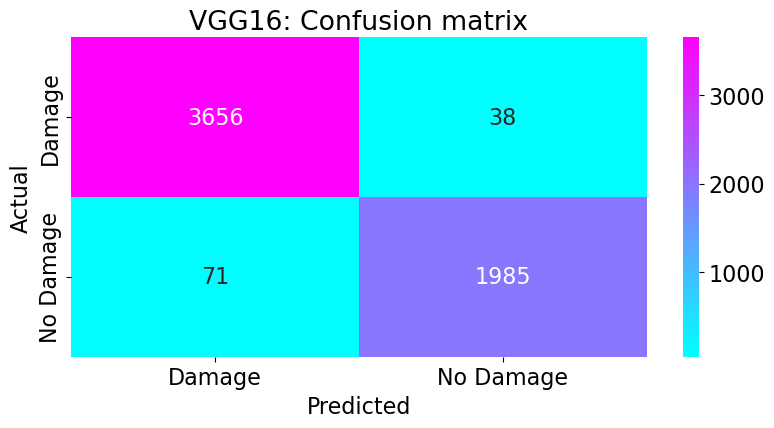

In [248]:
# Plot a confusion matrix
figure = plt.figure(figsize=(8, 4))
sns.heatmap(con_mat_df_vgg, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("VGG16: Confusion matrix") 
plt.show()

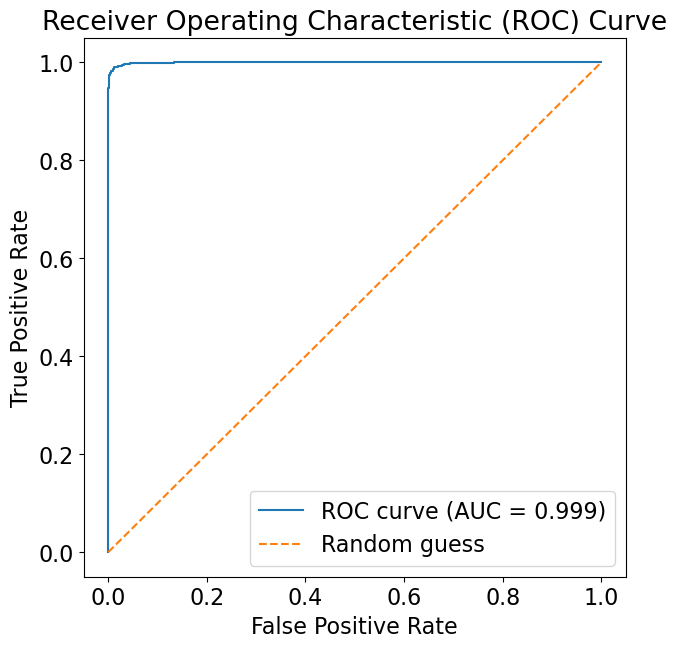

In [119]:
# Calculate the FPR and TPR
fpr_vgg, tpr_vgg, thresholds_vgg = roc_curve(data_test.labels, y_prob_1_vgg)
auc_score_vgg = roc_auc_score(data_test.labels, y_prob_1_vgg)
plt.figure(figsize=(7, 7))
# Plot the ROC curve
plt.plot(fpr_vgg, tpr_vgg, label=f'ROC curve (AUC = {auc_score_vgg:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [249]:
# Calculate metrics
con_mat_df_vgg.to_numpy()
confusion_metrics(con_mat_df_vgg.to_numpy())

True Positives: 1985
True Negatives: 3656
False Positives: 38
False Negatives: 71
--------------------------------------------------
Accuracy: 0.98
Mis-Classification: 0.02
Sensitivity: 0.97
Specificity: 0.99
Precision: 0.98
f_1 Score: 0.97
